In [28]:
import os, h5py
import pandas as pd
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
from datetime import datetime
import glob
import pyproj
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [43]:
## Create a dataframe for collecting all data
df = pd.DataFrame([], columns=["date", "lats", "lons", "night_flag", "max_canopy_height_m","data_quality_flag",
                              "canopy_openness", "canopy_flag", "h_canopy_uncertainty", "cloud_flag_atm", 
                              "water_mask", "landcover"])

### Extract data for each hdf5 file in the folder from Oct 2018 to Feb 2021

os.chdir('/home/shashank/Downloads/icesat2/icesat2_data/ATL08/')

for filename in sorted(glob.glob("*.h5")):
     print("working on %s" %filename)     
    
     #### Extract date from file name    
     date_str = filename.split("_")[1][0:8]
     date_obj  = datetime.strptime(date_str,'%Y%m%d')
     date = datetime.strftime(date_obj, '%d %B,%Y')
     
     ### Import the hdf file 
     f = h5py.File(filename, 'r')

     ### Extract data for all 3 strong beams
     beam_numbers = ['/gt1r', '/gt2r', '/gt3r']

     for beam in beam_numbers: 
  
         ### Extract required parameters from hdf
         lons = pd.DataFrame(f[beam + '/land_segments/longitude'][:])
         lats = pd.DataFrame(f[beam + '/land_segments/latitude'][:])
         night_flag = pd.DataFrame(f[beam + '/land_segments/night_flag'][:]) ## day=0, night=1 
         h_canopy = pd.DataFrame(f[beam + '/land_segments/canopy/h_canopy'][:]) ## 98 ptile of all canopy heights
         can_open = pd.DataFrame(f[beam + '/land_segments/canopy/canopy_openness'][:])
         can_flag = pd.DataFrame(f[beam + '/land_segments/canopy/canopy_flag'][:]) ## canopy present: 1; canopy not present: 0
         h_can_uncertainty = pd.DataFrame(f[beam + '/land_segments/canopy/h_canopy_uncertainty'][:])
         cloud_flag_atm = pd.DataFrame(f['gt1r/land_segments/cloud_flag_atm'][:]) ## Flag > 0: Clouds/aerosols could be present
         seg_watermask = pd.DataFrame(f['gt1r/land_segments/segment_watermask'][:]) ## 0:no water 1:water
         seg_landcover = pd.DataFrame(f['gt1r/land_segments/segment_landcover'][:]) ## MODIS landcover 17 classes http://www.worldhairsalon.com/sage/data-and-models/friedl_rse2010.pdf   
        
         ## Use quality flag information to filter data    
         ## Create a variable which counts the number of times '1' appears in the canopy flag
         ## -1: no data within geosegment available for analysis; 0: indicates no canopy photons within geosegment; 1: indicates canopy photons within geosegment
         ## For example, a 100 m ATL08 segment might have the following subset_can_flags: {-1 -1 -1 1 1} which would translate that no photons (canopy orground) were available for processing in the first three geosegments.
         canopy_flag = pd.DataFrame(f[beam + '/land_segments/canopy/subset_can_flag'][:]) 
         counter = pd.DataFrame([], index=np.arange(0, len(canopy_flag)), columns=["counter"])
         for i in range(0, len(counter)):
            count=0
            segment = canopy_flag.iloc[i,:]
            for j in range(0, 5):
                if segment[j] == 1:
                  count+=1
            counter["counter"][i] = count         
        
         ### Create a column of dates 
         dates_arr = []
         for i in range(0, len(h_canopy)):
            dates_arr.append(date)
            dates_df = pd.DataFrame(dates_arr, columns=["date"])
         
         ### Combine all the extracted parameters into a dataframe
         canopy_height_data = pd.concat([dates_df, lats, lons, night_flag, h_canopy, counter, can_open, can_flag,
                                        h_can_uncertainty, cloud_flag_atm, seg_watermask, 
                                        seg_landcover], axis=1, ignore_index=True)
         canopy_height_data.columns = df.columns
            
         ### Drop pixels with no-data value and canopy openness value equal to 3.4028235e+38
         ## Consider only pixels with h_canopy_uncertainty < 10
         canopy_height_data = canopy_height_data[canopy_height_data["max_canopy_height_m"] < 1e+38] 
         #canopy_height_data = canopy_height_data[canopy_height_data["canopy_openness"] < 1e+38]
         canopy_height_data = canopy_height_data[canopy_height_data["h_canopy_uncertainty"] < 10]
        
         ### Consider only pixels within the Cabo Rojo region
         canopy_height_data = canopy_height_data[canopy_height_data["lats"]>18]
         canopy_height_data = canopy_height_data[(canopy_height_data["lons"] > -67.20) &
                                                 (canopy_height_data["lons"] < -66.78)]
            
         ### Extract places with no cloud/aerosol cover and no water
         canopy_height_data = canopy_height_data[canopy_height_data["cloud_flag_atm"] == 0]
         canopy_height_data = canopy_height_data[canopy_height_data["water_mask"] == 0]   
    
         ### Extract only day/night time data and places with canopy flag=1
         canopy_height_data = canopy_height_data[canopy_height_data["night_flag"]==1]
         canopy_height_data = canopy_height_data[canopy_height_data["canopy_flag"]==1]
        
         ## Remove unwanted landcover classes permanent wetlands(11), urban(13), barren(16), water(17)
         canopy_height_data = canopy_height_data[(canopy_height_data["landcover"]!=13) &
                                                 (canopy_height_data["landcover"]<=14) &
                                                 (canopy_height_data["landcover"]!=11)]
        
         ### Extract data with data quality counter
         ## Most points have counter value 5. So, choosing only those. 
         canopy_height_data = canopy_height_data[canopy_height_data["data_quality_flag"]==5]
            
         ### Append canopy height data at the bottom of df
         df = df.append(canopy_height_data, ignore_index=True)

working on ATL08_20181028191317_04610101_004_01.h5
working on ATL08_20181101071043_05140107_004_01.h5
working on ATL08_20181126174916_09030101_004_01.h5
working on ATL08_20181130054639_09560107_004_01.h5
working on ATL08_20181130174056_09640101_004_01.h5
working on ATL08_20181229042247_00110207_004_01.h5
working on ATL08_20181229161704_00190201_004_01.h5
working on ATL08_20190102041429_00720207_004_01.h5
working on ATL08_20190127145314_04610201_004_01.h5
working on ATL08_20190131025040_05140207_004_01.h5
working on ATL08_20190225132918_09030201_004_01.h5
working on ATL08_20190301012641_09560207_004_01.h5
working on ATL08_20190301132058_09640201_004_01.h5
working on ATL08_20190330000240_00110307_004_01.h5
working on ATL08_20190330115657_00190301_004_01.h5
working on ATL08_20190402235420_00720307_004_01.h5
working on ATL08_20190428103256_04610301_004_01.h5
working on ATL08_20190501223018_05140307_004_01.h5
working on ATL08_20190527090853_09030301_004_01.h5
working on ATL08_20190530210615

In [44]:
print(df.head())
print(df.shape)

               date       lats       lons  night_flag  max_canopy_height_m  \
0  01 November,2018  18.190472 -66.780006         1.0            10.173981   
1  01 November,2018  18.121042 -66.787231         1.0            11.596375   
2  01 November,2018  18.113829 -66.787979         1.0            14.589569   
3  01 November,2018  18.111124 -66.788261         1.0            17.116760   
4  01 November,2018  18.107515 -66.788628         1.0            15.648834   

  data_quality_flag  canopy_openness  canopy_flag  h_canopy_uncertainty  \
0                 5         2.099076          1.0              4.546846   
1                 5         2.836726          1.0              8.691941   
2                 5         3.779113          1.0              8.795362   
3                 5         4.580658          1.0              8.992983   
4                 5         4.681450          1.0              7.248832   

  cloud_flag_atm water_mask landcover  
0              0          0         2  


In [45]:
### Convert the lat lons to UTM projection

proj_wgs84 = pyproj.Proj(init='epsg:4326')
proj_utm = pyproj.Proj(init='epsg:32620')

utmx = pd.DataFrame([], index=np.arange(0, len(df)), columns=["Northing"])
utmy = pd.DataFrame([], index=np.arange(0, len(df)), columns=["Easting"])

for i in range(0, len(df)):
   print(i)
   x, y = pyproj.transform(proj_wgs84, proj_utm, df["lons"][i], df["lats"][i])
   utmx["Northing"][i] = x
   utmy["Easting"][i] = y

df = pd.concat([df, utmx, utmy], axis=1, ignore_index=True)
df.columns = ["date", "lats", "lons", "night_flag", "max_canopy_height_m","data_quality_flag",
                              "canopy_openness", "canopy_flag", "h_canopy_uncertainty", "cloud_flag_atm", 
                              "water_mask", "landcover", "Northing", "Easting"]
df.to_csv("icesat2_max_canopy_height_all_hdfs_night.csv", sep=",", header=True, index=False, 
          columns=["Northing", "Easting","max_canopy_height_m","landcover"])

/home/shashank/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/shashank/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/shashank/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When mak

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
### GRASS GIS ###
### Imported the GliHt tiff file in UTM projection : Location glight and Mapset PERMANENT on linux laptop
### Created a raster map for ICESat2 max canopy heights in the same projection.
### Extracted the ICESat2 height for all locations where Gliht data is available

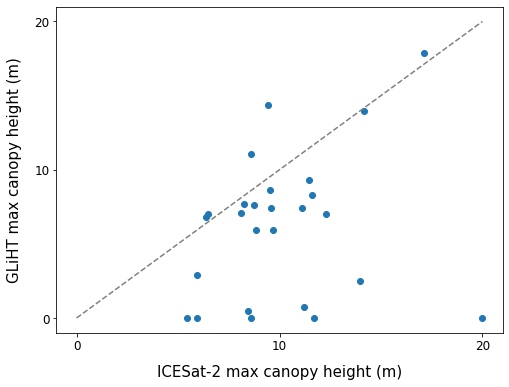

In [46]:
data = pd.read_csv("rstats_gliht_icesat_cabo_rojo_night", header=None, sep=" ", names=["gliht", "icesat2"])

## Remove outliers from data
data = data[(data["icesat2"] < 20) & (data["gliht"] < 20)]

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(data["icesat2"],data["gliht"],"o")
ax.set_xlabel("ICESat-2 max canopy height (m)", fontsize=15, labelpad=12)
ax.set_ylabel("GLiHT max canopy height (m)", fontsize=15, labelpad=12)
ax.set_xticks(np.arange(0,30,10))
ax.set_yticks(np.arange(0,30,10))
ax.set_xticklabels(np.arange(0,30,10), fontsize=12)
ax.set_yticklabels(np.arange(0,30,10), fontsize=12)
ax.plot(np.arange(0,30,10), np.arange(0,30,10), '--', c='grey')

# Linear regression
#reg = LinearRegression().fit(np.array(data["icesat2"]).reshape(-1, 1), np.array(data["gliht"]).reshape(-1, 1))
#m = reg.coef_[0][0]
#c = reg.intercept_
#ax.plot(data["icesat2"], m*data["icesat2"] + c, c='red')
#r2 = str(round(reg.score(np.array(data["icesat2"]).reshape(-1, 1), np.array(data["gliht"]).reshape(-1, 1)), 2))
#ax.text(0,18,"$R^2$ = %s" %r2, fontsize=14)
#ax.text(0,16,"slope = %s" %str(round(m, 2)), fontsize=14)

plt.show()

In [5]:
### Extract som more info from ATL08 products such as segment id, canopy openness, cloud mask etc.

os.chdir('/home/shashank/Downloads/icesat2/icesat2_data/ATL08')
f = h5py.File('ATL08_20181028191317_04610101_004_01.h5', 'r')
print(f.visit(print))

METADATA
METADATA/AcquisitionInformation
METADATA/AcquisitionInformation/lidar
METADATA/AcquisitionInformation/lidarDocument
METADATA/AcquisitionInformation/platform
METADATA/AcquisitionInformation/platformDocument
METADATA/DataQuality
METADATA/DataQuality/CompletenessOmission
METADATA/DataQuality/DomainConsistency
METADATA/DatasetIdentification
METADATA/Extent
METADATA/Lineage
METADATA/Lineage/ANC06-01
METADATA/Lineage/ANC06-02
METADATA/Lineage/ANC06-03
METADATA/Lineage/ANC14
METADATA/Lineage/ANC18
METADATA/Lineage/ANC19
METADATA/Lineage/ANC25-08
METADATA/Lineage/ANC26-08
METADATA/Lineage/ANC28
METADATA/Lineage/ANC33
METADATA/Lineage/ANC34
METADATA/Lineage/ANC36-08
METADATA/Lineage/ANC38-08
METADATA/Lineage/ATL03
METADATA/Lineage/ATL09
METADATA/Lineage/Control
METADATA/ProcessStep
METADATA/ProcessStep/Browse
METADATA/ProcessStep/Metadata
METADATA/ProcessStep/PGE
METADATA/ProcessStep/QA
METADATA/ProductSpecificationDocument
METADATA/QADatasetIdentification
METADATA/SeriesIdentification

(array([1628., 2879.,   17.,   52.,    0.,  608., 1074.,  679.,  166.,
         759.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <BarContainer object of 10 artists>)

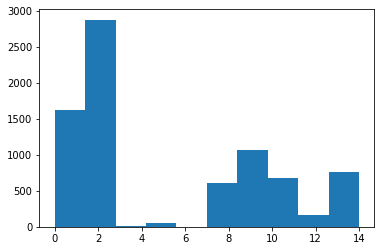

In [27]:
print(f['gt1r/signal_photons/ph_h'][:])
